In [1]:
trainingOHCA_fileName = "D:\MyDownloads\generatedPoints1_100000.csv"
candidateAED_fileName = "D:\MyDownloads\Singapore buildings locations.xlsx"
testOHCA_fileName = "D:\MyDownloads\generatedPoints2_100000.csv"
currentAED_fileName = "D:\MyDownloads\AED Details_As of 27 March 2019 (2).xlsx"

In [2]:
import pandas as pd
import numpy as np
from haversine import haversine_vector, Unit
from haversine import haversine
from os import path
import scipy.sparse
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
from pulp import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt     
import seaborn as sns
from itertools import combinations
from sklearn import preprocessing, cluster
from sklearn.metrics import silhouette_score
import scipy
import scipy.cluster
from matplotlib import colors as mcolors
from skimage.io import imread
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
import time

In [3]:
OHCA = pd.read_csv(trainingOHCA_fileName, names = ["LatOHCA", "LongOHCA"], header = None)
OHCA

,LatOHCA,LongOHCA
0,1.403902,103.857553
1,1.299905,103.820317
2,1.325750,103.721845
3,1.291553,103.801827
4,1.342320,103.692338
...,...,...
97537,1.444899,103.814294
97538,1.381748,103.822196
97539,1.273285,103.825616
97540,1.309153,103.779398


In [4]:
currentAED = pd.read_excel(currentAED_fileName)
currentAED = currentAED.drop(columns=['Postal Code'])
currentAED.columns = ["LatAED","LongAED"]
currentAED = currentAED.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
currentAED

,LatAED,LongAED
0,1.352654,103.973217
1,1.375489,103.738288
2,1.392346,103.747409
3,1.392310,103.746518
4,1.392493,103.745591
...,...,...
9875,1.282010,103.844418
9876,1.314315,103.852750
9877,1.341709,103.953151
9878,1.341856,103.953814


In [5]:
candidateAED = pd.read_excel(candidateAED_fileName)
candidateAED.columns = ["LatAED","LongAED"]
candidateAED

,LatAED,LongAED
0,1.275829,103.849576
1,1.274950,103.851665
2,1.279587,103.868956
3,1.273682,103.860075
4,1.279785,103.851529
...,...,...
141816,1.352316,103.966549
141817,1.433629,103.758648
141818,1.277170,103.795840
141819,1.375285,103.996737


In [6]:
test_OHCA = pd.read_csv(testOHCA_fileName, names = ["LatOHCA", "LongOHCA"], header = None)

# Defining functions

In [7]:
# Clustering functions

def elbow(dtf):
    ### Clustering k-means, elbow method
    X = dtf[["LatOHCA","LongOHCA"]]
    max_k = 50

    ## iterations
    distortions = [] 
    for i in range(1, max_k+1):
        if len(X) >= i:
            model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            model.fit(X)
            distortions.append(model.inertia_)
       
    ## best k: the lowest derivative
    k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

    ## plot

    fig, ax = plt.subplots()

    ax.plot(range(1, len(distortions)+1), distortions)
    #ax.axvline(k, ls='--', color="red", label="k = "+str(k))
    ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
    ax.legend()
    ax.grid(True)
    plt.show()
    return k
    
def kmeansOHCA(k): #k is the number of clusters chosen
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(OHCA)
    OHCA_Cluster_All = pd.concat([OHCA,pd.DataFrame(kmeans.labels_,columns = ["cluster"])],axis=1)
    return(OHCA_Cluster_All)

def kmeansPlot(k):
    colours = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
    for i in range(k):
        plt.scatter(x=OHCA_Cluster_All[OHCA_Cluster_All["cluster"]==i]["LatOHCA"], y= OHCA_Cluster_All[OHCA_Cluster_All["cluster"]==i]["LongOHCA"], s=5, c=colours[i])

def averageDist(OHCA_Cluster_All,k):
    averageDistList = []
    for i in range(k):
        OHCA_Cluster = OHCA_Cluster_All[OHCA_Cluster_All["cluster"]==i]
        coords = list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA))
        data = 0
        for j in range(len(coords)):
            for p in range(len(coords)):
                data = data + haversine(coords[j],coords[p],Unit.METERS)
        data = data/(len(coords)**2)
        averageDistList.append(data)
    return(averageDistList)

def average_distance(ohca_df, aed_df):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    
    return cp_ohca['dist_nearest_AED'].mean()


def getNumCases(OHCA_Cluster_All,k):
    casesPerCluster = []
    for i in range(k):
        OHCA_Cluster = OHCA_Cluster_All[OHCA_Cluster_All["cluster"]==i]
        casesPerCluster.append(len(OHCA_Cluster))
    return(casesPerCluster)

def getP(casesPerCluster,averageDistList,totalP):
    pList = []
    averageP = totalP/len(casesPerCluster)
    for i in range(len(casesPerCluster)):
        densityMultiplier = averageDistList[i]/(sum(averageDistList)/len(casesPerCluster))
        popMultiplier = casesPerCluster[i]/(sum(casesPerCluster)/len(casesPerCluster))
        pList.append(averageP*densityMultiplier*popMultiplier)
    return(pList)
#functions for individual clusters for optimization

# def clusterFilter(OHCA_Cluster_All,j): #returns coordinates belonging to cluster j
#     OHCA_Cluster = OHCA_Cluster_All[OHCA_Cluster_All["cluster"]==j]
#     OHCA_Cluster = OHCA_Cluster.reset_index(drop=True)
#     return(OHCA_Cluster)

# def maxmin(OHCA_Cluster): #returns the max/min for the cluster j
#     maxminList = []
#     maxminList.append(OHCA_Cluster.loc[OHCA_Cluster["LongOHCA"].idxmax()]["LongOHCA"])
#     maxminList.append(OHCA_Cluster.loc[OHCA_Cluster["LongOHCA"].idxmin()]["LongOHCA"])
#     maxminList.append(OHCA_Cluster.loc[OHCA_Cluster["LatOHCA"].idxmax()]["LatOHCA"])
#     maxminList.append(OHCA_Cluster.loc[OHCA_Cluster["LatOHCA"].idxmin()]["LatOHCA"])
#     return(maxminList)

# def AED_Filter(maxminList,AED): #filtering the AED coordinates based on the max/min. returns the AED coordinates of that cluster.
#     AED_Cluster = AED[AED["LatAED"] < (maxminList[2] + 0.01)]
#     AED_Cluster = AED_Cluster[AED_Cluster["LatAED"] > (maxminList[3] - 0.01)]
#     AED_Cluster = AED_Cluster[AED_Cluster["LongAED"] < (maxminList[0] + 0.01)]
#     AED_Cluster = AED_Cluster[AED_Cluster["LongAED"] > (maxminList[1] + 0.01)]
#     AED_Cluster = AED_Cluster.reset_index(drop=True)
#     return(AED_Cluster)

def kmeans_OHCA_AED(OHCA,AED,k): #k is the number of clusters chosen
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(OHCA)
    
    OHCA_Cluster_All = pd.concat([OHCA,pd.DataFrame(kmeans.labels_,columns = ["cluster"])],axis=1)
    AED_lable = kmeans.predict(AED)
    AED_Cluster_All = pd.concat([AED, pd.DataFrame(AED_lable,columns = ["cluster"])], axis=1)

    return OHCA_Cluster_All, AED_Cluster_All

def haverDist(OHCA_Cluster,AED_Cluster):
    d = haversine_vector(list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA)), list(zip(AED_Cluster.LatAED, AED_Cluster.LongAED)), Unit.METERS, comb=True).T
    return(d)

def pij(OHCA_Cluster,AED_Cluster):
    pij = haversine_vector(list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA)), list(zip(AED_Cluster.LatAED, AED_Cluster.LongAED)), Unit.METERS, comb=True).T
    pij = pij/(6.15*1000/60)*2
    pij = [[p if np.isnan(p) == False else 0 for p in s] for s in pij]
    pij = [[1 if p<=1 and p != 0 else p for p in s] for s in pij]
    pij = [[p if p<20 else 0 for p in s] for s in pij]
    pij = [[p if p==0 else ((p**-0.584)*0.549) for p in s] for s in pij]
    return(pij)

def coveragefunction(OHCA_Cluster,AED_Cluster):
    pij = haversine_vector(list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA)), list(zip(AED_Cluster.LatAED, AED_Cluster.LongAED)), Unit.METERS, comb=True).T
    pij = [[1 if p <= 20 else p for p in s] for s in pij]
    pij = [[np.exp(-0.05*(p - 20)) if p > 20 and p <= 100 else p for p in s] for s in pij]
    pij = [[0 if p>100 else p for p in s] for s in pij]
    return(pij)
    
def MCLP(S,OHCA_Cluster,AED_Cluster,d,P): #Input for MCLP to return the coordinates of AEDs to be placed
    
    # S is Distance beyond which is considered uncovered
    # P is the number of AEDs to be placed in that cluster 
    
    I = OHCA_Cluster.index.values.tolist() #Demand Node
    J = AED_Cluster.index.values.tolist() #Facility Node
    P = P
    #a = np.ones(len(OHCA_Cluster))
    
    # N is a list in which each item is a list of nodes within threshold distance of ith node
    N = [[j for j in J if d[i][j] < S] for i in I]
    #P = 2400 #Number of AEDs to be placed in this cluster
    
    #Optimization
    prob = LpProblem("MCLP",LpMaximize)
    x = LpVariable.dicts("x",J,0,1,cat="Integer")
    y = LpVariable.dicts("y",I,0,1,cat="Integer")
    #a = LpVariable.dicts("a",I,cat="Continuous")
    
    #Objective
    #prob += lpSum([a[i]*y[i] for i in I])
    prob += lpSum([y[i] for i in I])
    
    #Constraints
    for i in I:
        prob += lpSum([x[j] for j in N[i]]) >= y[i]
       # for j in N[i]:
            #if x[j] == 1:
                #prob += a[i] == 0.549*d[i][j]**-0.584
        #a[i] = [0.549*d[i][j]**-0.584 for j in N[i] if x[j] == 1]
        
    prob +=lpSum([x[j] for j in J]) == P

    #Solving
    #solver = getSolver('GUROBI')
    #prob.solve(solver)
    prob.solve(GUROBI(msg=0))
    
    x_soln = np.array([x[j].varValue for j in J])
    print ("OHCA Served is = ", value(prob.objective))
    AED_Chosen = pd.concat([AED_Cluster,pd.DataFrame(x_soln,columns=['x'])],axis=1)
    AED_Chosen = AED_Chosen[AED_Chosen['x'] == 1]
    AED_Chosen = AED_Chosen.drop(columns=['x'])
    return(AED_Chosen)


#Multi Responders
# def PCM1(S,OHCA_Cluster,AED_Cluster,pij,P):
#     J = OHCA_Cluster.index.values.tolist() #Demand Node
#     I = AED_Cluster.index.values.tolist()
    
#     #Decision Variables + Maximization
    
#     prob = LpProblem("PCM",LpMaximize)
#     r = LpVariable.dicts("r",J,0,1,cat="Continuous")
#     y = LpVariable.dicts("y",I,0,1,cat="Integer")
#     z = LpVariable.dicts("z",(I,J),0,1,cat="Continuous")
    
#     #objective
    
#     prob += lpSum([r[j] for j in J])
    
#     #Constraints
    
#     prob += lpSum([y[i] for i in I]) <= P
#     for i in I:
#         for j in J:
#             prob += z[i][j] == pij[j][i]*y[i]
#     for i in J:
#         prob += r[j] <= lpSum([z[i][j] for i in I])
    
#     solver = getSolver('GUROBI')
#     prob.solve(solver)
#     y_soln = np.array([y[i].varValue for i in I])
#     print("Coverage is ",value(prob.objective))
#     AED_Chosen = pd.concat([AED_Cluster,pd.DataFrame(y_soln,columns=['y'])],axis=1)
#     AED_Chosen = AED_Chosen[AED_Chosen['y'] == 1]
#     return(AED_Chosen)
#Doesn't seem to work, for the first cluster only 2 AEDs chosen?

#Single Responder best case
def PCM2(OHCA_Cluster,AED_Cluster,pij,P):
    J = OHCA_Cluster.index.values.tolist()
    I = AED_Cluster.index.values.tolist()
    
    #Decision Variables + Maximization
    
    prob = LpProblem("PCM",LpMaximize)
    w = LpVariable.dicts("w",(I,J),0,1,cat = "Integer")
    y = LpVariable.dicts("y",I,0,1,cat="Integer")
    
    #objective
    
    prob += lpSum([pij[j][i]*w[i][j] for i in I for j in J if pij[j][i] > 0])
    
    #constraints
    
    for j in J:
        for i in I:
            if (pij[j][i] > 0):
                prob += w[i][j] <= y[i]
    for j in J:
        prob += lpSum([w[i][j] for i in I if pij[j][i] > 0]) <= 1
    
    prob += lpSum([y[i] for i in I]) <= P
    prob.solve(GUROBI(msg=0))
    y_soln = np.array([y[i].varValue for i in I])
    print("Coverage is ",value(prob.objective))
    AED_Chosen = pd.concat([AED_Cluster,pd.DataFrame(y_soln,columns=['y'])],axis=1)
    AED_Chosen = AED_Chosen[AED_Chosen['y'] == 1]
    AED_Chosen = AED_Chosen.drop(columns=['y'])
    return(AED_Chosen)

def pmedian(OHCA_Cluster,AED_Cluster,d,P):
    I = OHCA_Cluster.index.values.tolist()
    J = AED_Cluster.index.values.tolist()
    
    #Decision Variables + Minimization
    
    prob = LpProblem("P-Median",LpMinimize)
    y = LpVariable.dicts("y",(I,J),0,1,cat = "Integer")
    x = LpVariable.dicts("x",J,0,1,cat = "Integer")
    
    #objective
    
    prob += lpSum([d[i][j]*y[i][j] for i in I for j in J])
    
    #constraints
    
    for i in I:
        prob += lpSum([y[i][j] for j in J]) == 1
    
    for i in I:
        for j in J:
            prob += y[i][j] - x[j] <= 0
    
    prob += lpSum(x[j] for j in J) == P
    solver = getSolver('GUROBI')
    prob.solve(solver)
    
    x_soln = np.array([x[j].varValue for j in J])
    print ("OHCA Served is = ", value(prob.objective))
    AED_Chosen = pd.concat([AED_Cluster,pd.DataFrame(x_soln,columns=['x'])],axis=1)
    AED_Chosen = AED_Chosen[AED_Chosen['x'] == 1]
    AED_Chosen = AED_Chosen.drop(columns=['x'])
    return(AED_Chosen)
    
def filterAED(AED_Chosen_All):
    AED_Chosen_All = AED_Chosen_All.drop_duplicates()
    AED_Chosen_All = AED_Chosen_All.reset_index(drop = True)
    return(AED_Chosen_All)

def expectedsurvival(OHCA,AED):
    prob = 0
    for i in range(len(OHCA)):
        survival = haversine_vector((OHCA.LatOHCA[i], OHCA.LongOHCA[i]), list(zip(AED.LatAED, AED.LongAED)), Unit.METERS, comb=True).T[0]
        survival = survival/(6.15*1000/60)*2
        survival = [p if np.isnan(p) == False else 0 for p in survival]
        survival = [1 if p<=1 and p != 0 else p for p in survival]
        survival = [p if p<20 else 0 for p in survival]
        survival = [p if p==0 or p == 1 else ((p**-0.584)*0.549) for p in survival]
        prob += max(survival)
    expectedSurvival = prob/len(OHCA)
    return(expectedSurvival)

def totalCoverage(ohca_df, aed_df, MAX_DIST_METERS = 100):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000
    
    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 100, 'isCovered'] = 'covered'
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] > 100,'isCovered'] = 'uncovered'
    # each OHCA having an AED within 100m has isCovered = 'covered', otherwise 'uncovered'
    #print(cp_ohca)
    
    
    within_100m  = sum(cp_ohca['isCovered'] == 'covered')
    outside_100m = len(cp_ohca) - within_100m
    total_coverage_within_100m = within_100m / (within_100m + outside_100m)
    print("total coverage = ", total_coverage_within_100m)
    
    return total_coverage_within_100m

def partial_coverage(ohca_df, aed_df, ALPHA = 0.05):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 20,'p_ij_coverage'] = 1.0
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] >= 100,'p_ij_coverage'] = 0.0
    cp_ohca.loc[(cp_ohca['dist_nearest_AED'] < 100) & (cp_ohca['dist_nearest_AED'] > 20),
                'p_ij_coverage'] = np.exp(- ALPHA * (cp_ohca['dist_nearest_AED'] - 20))
    # p_ij of each OHCA calulated
    # print(cp_ohca)
    
    return cp_ohca['p_ij_coverage'].mean()

def visualise_zero_covered(ohca_df, aed_df, MAX_DIST_METERS = 100):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000
    
    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 100, 'isCovered'] = 'covered'
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] > 100,'isCovered'] = 'uncovered'
    # each OHCA having an AED within 100m has isCovered = 'covered', otherwise 'uncovered'
    #print(cp_ohca)
    

    plt.figure(figsize=(10,7))
    img = imread('SgpBox.jpg')

    plt.imshow(img,zorder=0,extent=[103.5914, 104.09102,
                                    1.18864, 1.48647])
    ax = plt.gca()
    colors = {'covered':'red', 'uncovered':'blue'}
    grouped = cp_ohca.groupby('isCovered')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='LongOHCA', y='LatOHCA', label=key, color=colors[key],s=1)

    plt.show()
    
    return cp_ohca['isCovered'].value_counts()

def RecursiveOptimization(OHCA_All,AED_Chosen,AED_All,Max_AED = 12000):
    ohcaUncovered = pd.DataFrame(columns = ['LatOHCA','LongOHCA'])
    AED_Chosen_All_PCM = pd.DataFrame(columns = ['LatAED','LongAED'])
    k=7
    for i in range(len(OHCA_All)):
        coverage = haversine_vector((OHCA_All.LatOHCA[i], OHCA_All.LongOHCA[i]), list(zip(AED_Chosen.LatAED, AED_Chosen.LongAED)), Unit.METERS, comb=True).T[0]
        coverage = [1 if dist <= 100 else 0 for dist in coverage]
        if (max(coverage) == 0):
            ohcaUncovered = ohcaUncovered.append(OHCA_All[i:i+1])
    ohcaUncovered = ohcaUncovered.reset_index(drop=True)
    #filtering all AEDs not inside AED_Chosen_All
    keys = list(AED_Chosen.columns.values)
    i1 = AED_All.set_index(keys).index
    i2 = AED_Chosen.set_index(keys).index
    excludedAED = AED[~i1.isin(i2)]
    
    #cluster and get P list
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(ohcaUncovered)
    OHCA_Cluster_All = pd.concat([ohcaUncovered,pd.DataFrame(kmeans.labels_,columns = ["cluster"])],axis=1)
    averageDistList = averageDist(OHCA_Cluster_All,k)
    casesPerCluster = getNumCases(OHCA_Cluster_All,k)
    P_list = getP(casesPerCluster,averageDistList,(Max_AED - len(AED_Chosen)))
    del averageDistList
    del casesPerCluster
    del keys
    del i1
    del i2
    del kmeans
    
    for i in range(k):
        P = int(P_list[i])
        OHCA_Cluster = clusterFilter(OHCA_Cluster_All,i)
        maxminList = maxmin(OHCA_Cluster)
        AED_Cluster = AED_Filter(maxminList,excludedAED)
        prob_pij = coveragefunction(OHCA_Cluster,AED_Cluster)
        AED_Chosen_PCM = PCM2(OHCA_Cluster,AED_Cluster,prob_pij,P)
        AED_Chosen_All_PCM = AED_Chosen_All_PCM.append(AED_Chosen_PCM)
        del P
        del OHCA_Cluster
        del maxminList
        del AED_Cluster
        del prob_pij
        del AED_Chosen_PCM

    #latest AEDs
    AED_Chosen_All_PCM = filterAED(AED_Chosen_All_PCM)
    newAED_Chosen = AED_Chosen.append(AED_Chosen_All_PCM,ignore_index = True)
    oldCoverage = expectedsurvival(OHCA_All,AED_Chosen)
    newCoverage = expectedsurvival(OHCA_All,newAED_Chosen)
    percentageImprovement = (newCoverage - oldCoverage)/oldCoverage*100
    #del AED_Chosen_All_PCM
    
    print("Cycle done. Percentage improvement is", percentageImprovement)
    
    if (len(newAED_Chosen) >= 11500):
        display(newAED_Chosen)
        return(newAED_Chosen)
    elif(percentageImprovement >= 5):
        return(RecursiveOptimization(OHCA_All,newAED_Chosen, AED_All, Max_AED = 12000))
    else:
        display(newAED_Chosen)
        return(newAED_Chosen)

## 1. MCLP

In [8]:
S = 100

In [10]:
P = 9880
OHCA_Cluster = OHCA
AED_Cluster = candidateAED
d = haverDist(OHCA_Cluster,AED_Cluster)
AED_Chosen_MCLP = MCLP(S,OHCA_Cluster,AED_Cluster,d,P)

MemoryError: Unable to allocate 103. GiB for an array with shape (141821, 97542) and data type float64

## 2. PCM

In [15]:
P = 9880
OHCA_Cluster = OHCA
AED_Cluster = candidateAED
prob_pij = coveragefunction(OHCA_Cluster,AED_Cluster)
AED_Chosen_PCM = PCM2(OHCA_Cluster,AED_Cluster,prob_pij,P)
#AED_Chosen_All_PCM = AED_Chosen_All_PCM.append(AED_Chosen_PCM)

MemoryError: Unable to allocate 103. GiB for an array with shape (141821, 97542) and data type float64

# Clustering training OHCA

No handles with labels found to put in legend.


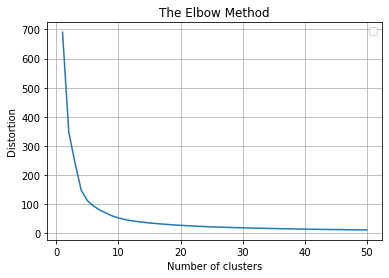

35

In [16]:
elbow(OHCA)

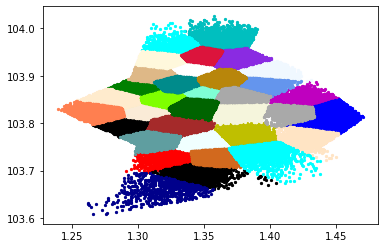

In [20]:
AED_Chosen_All_MCLP = pd.DataFrame(columns = ['LatAED','LongAED'])
AED_Chosen_All_PCM = pd.DataFrame(columns = ['LatAED','LongAED'])

k=35
S = 100
OHCA_Cluster_All = kmeansOHCA(k)
kmeansPlot(k)

In [23]:
averageDistList = averageDist(OHCA_Cluster_All,k)
casesPerCluster = getNumCases(OHCA_Cluster_All,k)
P_list = getP(casesPerCluster,averageDistList,9880)

# 3. Multiple MCLP

In [8]:
def MCLP_in_Cluster(OHCA1,candidateAED1,p_subzone,k=2):
    OHCA1_clusters, candidateAED1_clusters = kmeans_OHCA_AED(OHCA1, candidateAED1,k)
    All_AED_in_Cluster=pd.DataFrame(columns=['LatAED', 'LongAED']) 
    number_sub_AED = int(p_subzone/k)
    for i in range(k):
        OHCA20a = OHCA1_clusters[OHCA1_clusters['cluster']==i][["LatOHCA","LongOHCA"]].reset_index(drop=True)
        candidateAED20a = candidateAED1_clusters[candidateAED1_clusters['cluster']==i][["LatAED","LongAED"]].reset_index(drop=True)
        if len(candidateAED20a)>0:
            d1 = haverDist(OHCA20a,candidateAED20a)
            p_sub=int(p_subzone*len(OHCA20a)/len(OHCA1))
            print(i,len(OHCA20a), p_sub)
            sub_AED_df = MCLP(100,OHCA20a,candidateAED20a,d1,p_sub)
            All_AED_in_Cluster=All_AED_in_Cluster.append(sub_AED_df)
            print(len(All_AED_in_Cluster))
        else: pass
    return All_AED_in_Cluster

In [15]:
%%time

start_time = time.time()

AED_Chosen_All_MCLP= pd.DataFrame(columns=['LatAED', 'LongAED']) 
all_AED_num=9880
all_OHCA_num=97542
k= 55
AED_Chosen_All_MCLP =MCLP_in_Cluster(OHCA,candidateAED,all_AED_num,55)

print("--- %s seconds ---" % (time.time() - start_time))

0 2177 220
179
OHCA Served is =  1599.0
1 2089 211
179
OHCA Served is =  1272.0
2 2097 212
179
OHCA Served is =  1726.0
3 1473 149
179
OHCA Served is =  585.0
4 1447 146
179
OHCA Served is =  716.0
5 2325 235
179
OHCA Served is =  1920.0
6 2432 246
179
OHCA Served is =  2288.0
7 1574 159
179
OHCA Served is =  1183.0
8 2496 252
179
OHCA Served is =  2326.0
9 1342 135
179
OHCA Served is =  580.0
10 1710 173
179
OHCA Served is =  1401.0
11 1872 189
179
OHCA Served is =  1177.0
12 2323 235
179
OHCA Served is =  2006.0
13 2321 235
179
OHCA Served is =  1858.0
14 1542 156
179
OHCA Served is =  1148.0
15 1962 198
179
OHCA Served is =  1216.0
16 1971 199
179
OHCA Served is =  1817.0
17 1809 183
179
OHCA Served is =  1259.0
18 2029 205
179
OHCA Served is =  1761.0
19 1230 124
179
OHCA Served is =  636.0
20 2191 221
179
OHCA Served is =  1775.0
21 1286 130
179
OHCA Served is =  731.0
22 451 45
179
OHCA Served is =  116.0
23 2132 215
179
OHCA Served is =  1094.0
24 1906 193
179
OHCA Served is =  

In [17]:
AED_Chosen_All_MCLP.to_csv('MCLP35_All_AED_Chosen-WholeSG.csv')
AED_Chosen_All_MCLP

,LatAED,LongAED
0,1.275829,103.849576
1,1.274950,103.851665
2,1.273682,103.860075
11,1.275241,103.853659
12,1.277681,103.850157
...,...,...
519,1.392396,103.916662
520,1.393043,103.917401
521,1.394127,103.917122
524,1.396464,103.912450


In [9]:
# --- 326.85805320739746 seconds ---
# Wall time: 5min 26s

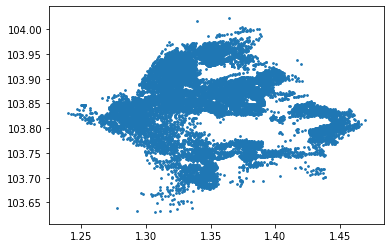

In [19]:
plt.scatter(
   AED_Chosen_All_MCLP['LatAED'], 
   AED_Chosen_All_MCLP['LongAED'],s=3
)

In [11]:
#AED_Chosen_All_MCLP = pd.read_csv("MCLP_SingleBest_Output.csv",index_col=0)
#total coverage 
MCLP_TC = totalCoverage(OHCA,AED_Chosen_All_MCLP,100)
print("MCLP total coverage is : ", MCLP_TC)
#partial coverage
MCLP_PC = partial_coverage(OHCA,AED_Chosen_All_MCLP)
print("MCLP partial coverage is : ", MCLP_PC)
#expected survival
MCLP_ES = expectedsurvival(OHCA,AED_Chosen_All_MCLP)
print("MCLP expected survival is : ", MCLP_ES)
#average distance to nearest AED


total coverage =  0.7002829550347542
MCLP total coverage is :  0.7002829550347542
MCLP partial coverage is :  0.16007355012600055
MCLP expected survival is :  0.5057805456672272


In [12]:
MCLP_AD = average_distance(OHCA, AED_Chosen_All_MCLP)
print("MCLP average distance is : ", MCLP_AD)

MCLP average distance is :  146.391523654198


# 4. Multiple PCM

In [13]:
def PCM_in_Cluster(OHCA1,candidateAED1,p_subzone,k=3):
    OHCA1_clusters, candidateAED1_clusters = kmeans_OHCA_AED(OHCA1, candidateAED1,k)
    All_AED_in_Cluster=pd.DataFrame(columns=['LatAED', 'LongAED']) 
    for i in range(k):
        OHCA20a = OHCA1_clusters[OHCA1_clusters['cluster']==i][["LatOHCA","LongOHCA"]].reset_index(drop=True)
        candidateAED20a = candidateAED1_clusters[candidateAED1_clusters['cluster']==i][["LatAED","LongAED"]].reset_index(drop=True)
        if len(OHCA20a)>0 and len(candidateAED20a)>0:
                p_sub=int(p_subzone*len(OHCA20a)/len(OHCA1))
                print(i,len(OHCA20a), p_sub)
                prob_pij = coveragefunction(OHCA20a,candidateAED20a)
                sub_AED_df = PCM2(OHCA20a,candidateAED20a,prob_pij,p_sub)
                All_AED_in_Cluster=All_AED_in_Cluster.append(sub_AED_df)
                print(len(All_AED_in_Cluster))
        else: pass
    return All_AED_in_Cluster

In [11]:
%%time

start_time = time.time()

ALL_AED= pd.DataFrame(columns=['LatAED', 'LongAED']) 
all_AED_num=9880
all_OHCA_num=97542
k=55
ALL_AED =PCM_in_Cluster(OHCA,candidateAED,all_AED_num,55)

print("--- %s seconds ---" % (time.time() - start_time))

0 2177 220
Academic license - for non-commercial use only - expires 2022-06-25
Using license file C:\Users\ISEdzh\gurobi.lic
Coverage is  623.184410478043
220
1 2089 211
Coverage is  468.05519409067995
431
2 2097 212
Coverage is  657.2967968727885
643
3 1473 149
Coverage is  263.32505151881765
792
4 1447 146
Coverage is  209.2749272034854
938
5 2325 235
Coverage is  721.5730772214705
1173
6 2432 246
Coverage is  872.1868605254108
1419
7 1574 159
Coverage is  394.8871282120996
1578
8 2496 252
Coverage is  855.1084654924496
1830
9 1342 135
Coverage is  217.98560651732961
1965
10 1710 173
Coverage is  455.436943597778
2138
11 1872 189
Coverage is  444.9875040380485
2327
12 2323 235
Coverage is  738.4105272575531
2562
13 2321 235
Coverage is  589.6589864909186
2797
14 1542 156
Coverage is  402.25399195928077
2953
15 1962 198
Coverage is  405.28671842166233
3151
16 1971 199
Coverage is  660.1501667490243
3350
17 1809 183
Coverage is  413.2300179063015
3533
18 2029 205
Coverage is  581.45654

In [8]:
# --- 1371.481431722641 seconds ---
# # Wall time: 22min 51s

In [12]:
AED_Chosen_All_PCM = ALL_AED.copy()
AED_Chosen_All_PCM.to_csv('PCM_All_AED_Chosen-K55.csv')
AED_Chosen_All_PCM

,LatAED,LongAED
2,1.273682,103.860075
11,1.275241,103.853659
16,1.277372,103.852845
29,1.278746,103.851271
32,1.278229,103.850813
...,...,...
525,1.392283,103.915512
527,1.399509,103.916575
529,1.393909,103.912581
530,1.396912,103.908950


In [11]:
#total coverage 
PCM_TC = totalCoverage(OHCA,AED_Chosen_All_PCM,100)
print("PCM total coverage is : ", PCM_TC)
#partial coverage
PCM_PC = partial_coverage(OHCA,AED_Chosen_All_PCM)
print("PCM partial coverage is : ", PCM_PC)
#expected survival
PCM_ES = expectedsurvival(OHCA,AED_Chosen_All_PCM)
print("PCM expected survival is : ", PCM_ES)
#average distance to nearest AED

total coverage =  0.5930778536425335
PCM total coverage is :  0.5930778536425335
PCM partial coverage is :  0.2519690300594077
PCM expected survival is :  0.5486503230813419


In [12]:
PCM_AD = average_distance(OHCA, AED_Chosen_All_PCM)
print("PCM average distance is : ", PCM_AD)

PCM average distance is :  176.5610557054144


## Results on Test set

In [15]:
#total coverage 
MCLP_TC = totalCoverage(test_OHCA,AED_Chosen_All_MCLP,100)
print("MCLP total coverage is : ", MCLP_TC)
#partial coverage
MCLP_PC = partial_coverage(test_OHCA,AED_Chosen_All_MCLP)
print("MCLP partial coverage is : ", MCLP_PC)
#expected survival
MCLP_ES = expectedsurvival(test_OHCA,AED_Chosen_All_MCLP)
print("MCLP expected survival is : ", MCLP_ES)
#average distance to nearest AED
MCLP_AD = average_distance(test_OHCA, AED_Chosen_All_MCLP)
print("MCLP average distance is : ", MCLP_AD)

total coverage =  0.6239413513790628
MCLP total coverage is :  0.6239413513790628
MCLP partial coverage is :  0.15028089134918368
MCLP expected survival is :  0.49190629793815044
MCLP average distance is :  150.7669167339193


In [16]:
#total coverage 
PCM_TC = totalCoverage(test_OHCA,AED_Chosen_All_PCM,100)
print("PCM total coverage is : ", PCM_TC)
#partial coverage
PCM_PC = partial_coverage(test_OHCA,AED_Chosen_All_PCM)
print("PCM partial coverage is : ", PCM_PC)
#expected survival
PCM_ES = expectedsurvival(test_OHCA,AED_Chosen_All_PCM)
print("PCM expected survival is : ", PCM_ES)
#average distance to nearest AED
PCM_AD = average_distance(test_OHCA, AED_Chosen_All_PCM)
print("PCM average distance is : ", PCM_AD)

total coverage =  0.5480057418230289
PCM total coverage is :  0.5480057418230289
PCM partial coverage is :  0.15192303003106863
PCM expected survival is :  0.47648280430508305
PCM average distance is :  186.5963971979369


## Performance Comparison against Current AED

In [17]:
#total coverage 
current_TC = totalCoverage(test_OHCA,currentAED,100)
print("current total coverage is : ", current_TC)
#partial coverage
current_PC = partial_coverage(test_OHCA,currentAED)
print("current partial coverage is : ", current_PC)
#expected survival
current_ES = expectedsurvival(test_OHCA,currentAED)
print("current expected survival is : ", current_ES)
#average distance to nearest AED
current_AD = average_distance(test_OHCA, currentAED)
print("current average distance is : ", current_AD)

total coverage =  0.3879216651286784
current total coverage is :  0.3879216651286784
current partial coverage is :  0.11957687513029731
current expected survival is :  0.4040399979722174
current average distance is :  246.83777782467837
